In [1]:
#Here I am Importing the required libraries
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimension: (540, 960, 3)


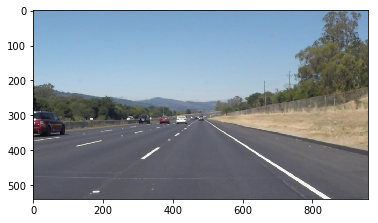

In [2]:
#This cellblock will load and display an image
image = mpimg.imread('test_images/SolidWhiteRight.jpg')
#Printing image stats and sizes
print('This image is: {} with dimension: {}'.format(type(image), image.shape))
plt.imshow(image)

In [3]:
#defined functions

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(gray, kernel_size):
    return cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

def canny(blur, low_threshold, high_threshold):
    return cv2.Canny(blur, low_threshold, high_threshold)

def apply_mask(edges, image, gray):
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    
    imshape = image.shape
    
   
    vertices = np.array([[(0, imshape[0]), (imshape[1] * 9 / 20, imshape[0] * 3 / 5),
                         (imshape[1] * 11 / 20, imshape[0] * 3 / 5), (imshape[1], imshape[0])]], dtype=np.int32)
    
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    (masked_image, mask) = region_of_interest(edges, vertices)
    return masked_image

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)

    return (masked_image, mask)

def apply_hough(masked_image):
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 40
    max_line_gap = 20
    
    hough_image, lines = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    return hough_image, lines

def hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap):
    hough_lines =cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]), minLineLength=min_line_length,
                                 maxLineGap=max_line_gap)
    line_img = np.zeros((*masked_image.shape, 3), dtype=np.uint8)
    
    draw_lines(line_img, hough_lines)
    
    return (line_img, hough_lines)

prev_left_x_min = None
prev_left_x_max = None
prev_right_x_min = None
prev_right_x_max = None

def draw_lines(line_img, hough_lines, color=[0, 255, 0], thickness=11):
    x1_values = hough_lines[:, :, 0]
    y1_values = hough_lines[:, :, 1]
    x2_values = hough_lines[:, :, 2]
    y2_values = hough_lines[:, :, 3]
    
    global prev_left_x_min
    global prev_left_x_max
    global prev_right_x_min
    global prev_right_x_max

    y_max = max(np.amax(y1_values), np.amax(y2_values))
    y_min = max(np.amin(y1_values), np.amin(y2_values))
    
    left_slopes = []
    right_slopes = []
    
    left_lane = []
    right_lane = []
    
    for line in hough_lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
        
            if(-0.9 < slope < -0.6):
                left_slopes.append(slope)
                left_lane.append(line)
            elif(0.45 < slope < 0.7):
                right_slopes.append(slope)
                right_lane.append(line)
                
    left_slopes_arr = np.array(left_slopes)
    right_slopes_arr = np.array(right_slopes)
    
    left_lane_arr = np.array(left_lane)       
    right_lane_arr = np.array(right_lane)
    
    left_lane_slope_average = np.mean(left_slopes_arr)
    right_lane_slope_average = np.mean(right_slopes_arr)
    
    y_max = int(y_max)
    y_min = int(y_min)
    
    if len(left_lane_arr) > 0:
        y_intercept_left_lane_average = np.mean(left_lane_arr[:, :, 1] - (left_lane_arr[:, :, 0] * left_lane_slope_average))
        
        x_max_left = int((y_max - y_intercept_left_lane_average) / left_lane_slope_average)
        x_min_left = int((y_min - y_intercept_left_lane_average) / left_lane_slope_average)
        
        cv2.line(line_img, (x_max_left, y_max), (x_min_left, y_min), color, thickness)
        
        prev_left_x_max = x_max_left
        prev_left_x_min = x_min_left
        
    else:
        if prev_left_x_max is not None:
            print('prev_left_x_max is not None')
            cv2.line(line_img, (prev_left_x_max, y_max), (prev_left_x_min, y_min), color, thickness)
        
        else:
            print('Nothing')
            
    if len(right_lane_arr) > 0:
        y_intercept_right_lane_average = np.mean(right_lane_arr[:, :, 1] - (right_lane_arr[:, :, 0] * right_lane_slope_average))
        
        x_max_right = int((y_max - y_intercept_right_lane_average) / right_lane_slope_average)
        x_min_right = int((y_min - y_intercept_right_lane_average) / right_lane_slope_average)
        
        cv2.line(line_img, (x_max_right, y_max), (x_min_right, y_min), color, thickness)
        
        prev_right_x_max = x_max_right
        prev_right_x_min = x_min_right
        
    else:
        if prev_left_x_max is not None:
            print('prev_right_x_max is not None')
            cv2.line(line_img, (prev_right_x_max, y_max), (prev_right_x_min, y_min), color, thickness)
        
        else:
            print('Nothing')
            
def apply_hough_lines_weighted(image, edges, hough_image):
    hough_lines_weighted = weighted_image(hough_image, image)
    return hough_lines_weighted

def weighted_image(hough_image, original_image, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(original_image, α, hough_image, β, λ)
    

    


In [4]:
#Plotting of Original, Gray, Blurred, Edged and Masked images

def plot_original_gray_blur(original, gray, blur):
    fig = plt.figure(figsize = (20, 10))
    
    a = fig.add_subplot(3,1,1)
    a.set_title('Original')
    edgeplot = plt.imshow(original)

    a = fig.add_subplot(3,1,2)
    a.set_title('Gray')
    edgeplot = plt.imshow(gray, cmap="gray")
    
    a = fig.add_subplot(3,1,3)
    a.set_title('Blur')
    edgeplot = plt.imshow(blur, cmap="gray")
    plt.show()
    
def plot_edges_mask(edges, image, masked_image):
    fig = plt.figure(figsize = (20, 10))
    
    a = fig.add_subplot(3,1,1)
    a.set_title('Edges')
    edgeplot = plt.imshow(edges, cmap="gray")
    
    a = fig.add_subplot(3,1,2)
    a.set_title('Image')
    edgeplot = plt.imshow(image)
    
    a = fig.add_subplot(3,1,3)
    a.set_title('Masked Image')
    edgeplot = plt.imshow(masked_image, cmap="gray")
    plt.show()

def plot_hough(hough_image, masked_image):
    fig = plt.figure(figsize = (20, 10))
    
    a = fig.add_subplot(2,1,1)
    a.set_title('Masked Image')
    edgeplot = plt.imshow(masked_image, cmap="gray")
    
    a = fig.add_subplot(2,1,2)
    a.set_title('Hough Image')
    edgeplot = plt.imshow(hough_image)
    plt.show()

def plot_hough_weighted(hough_lines_weighted):
    plt.imshow(hough_lines_weighted)

   

Images: ['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


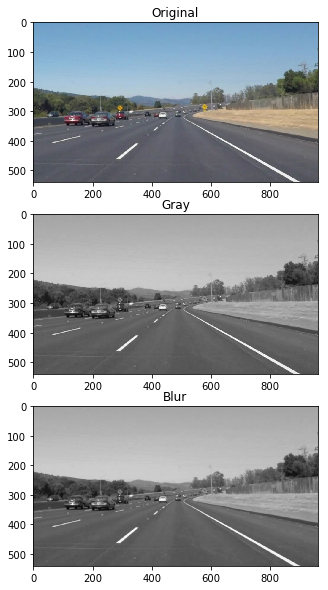

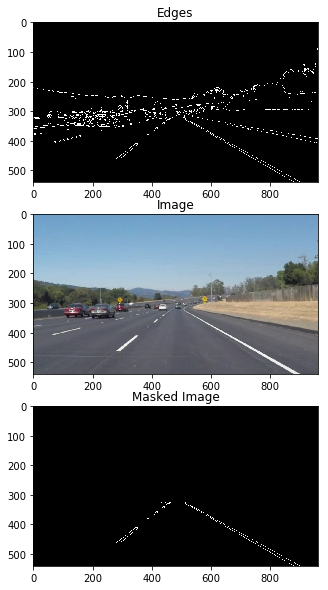

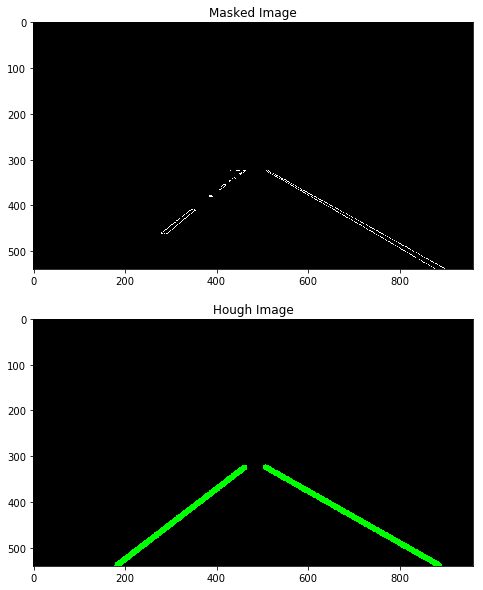

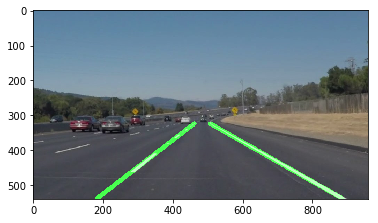

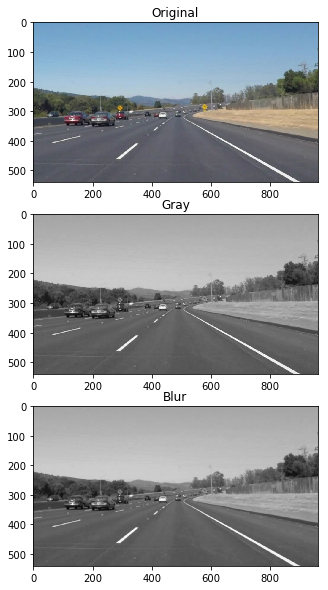

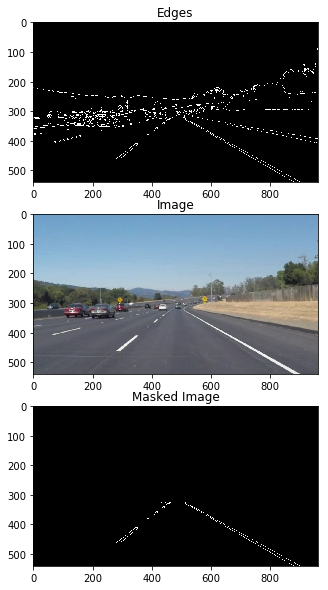

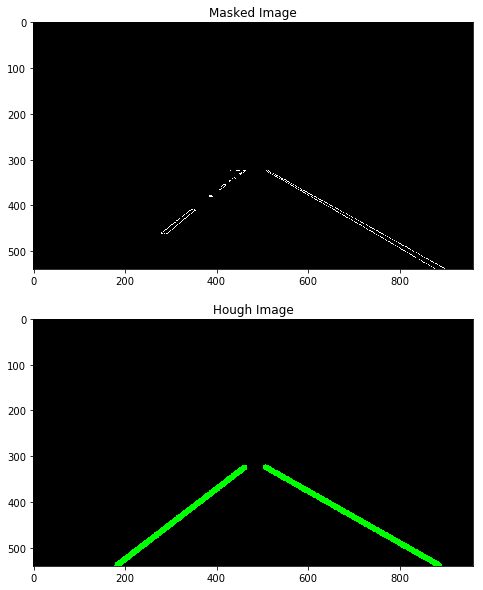

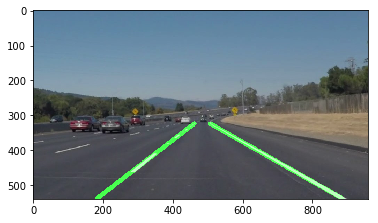

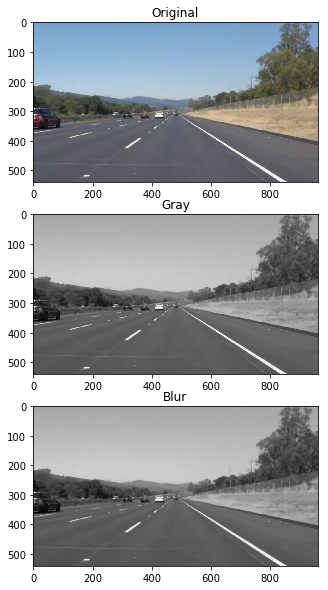

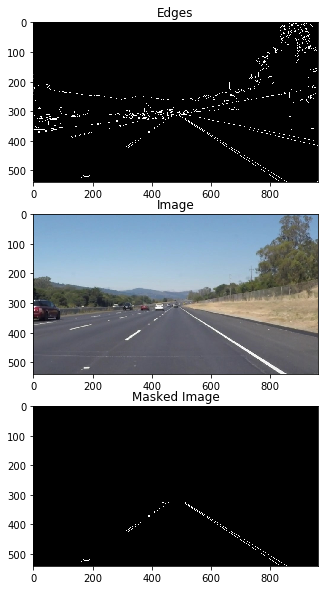

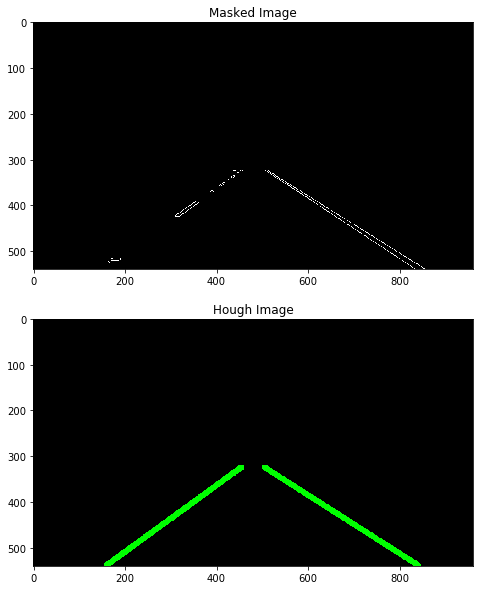

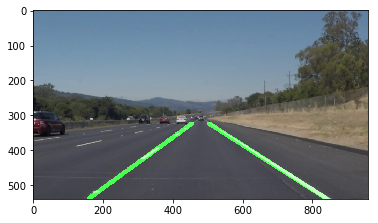

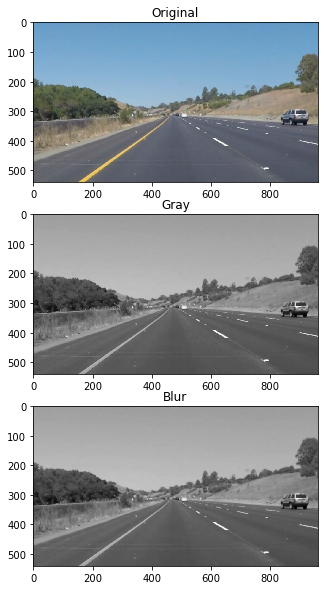

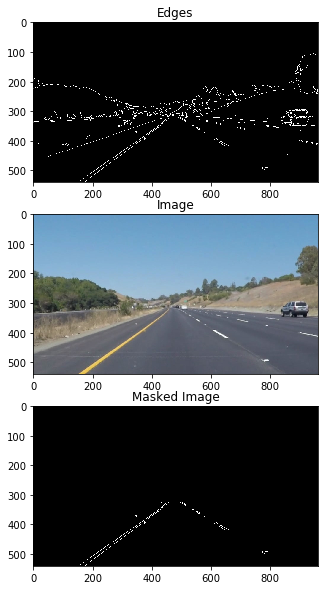

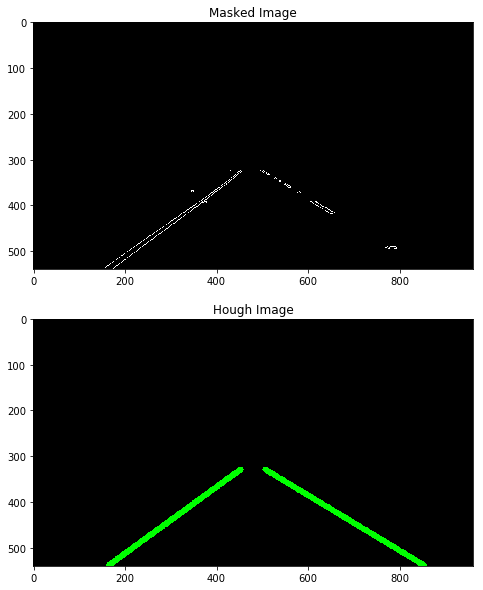

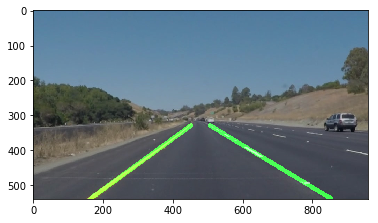

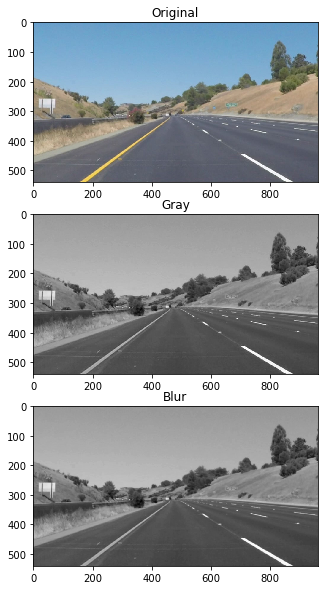

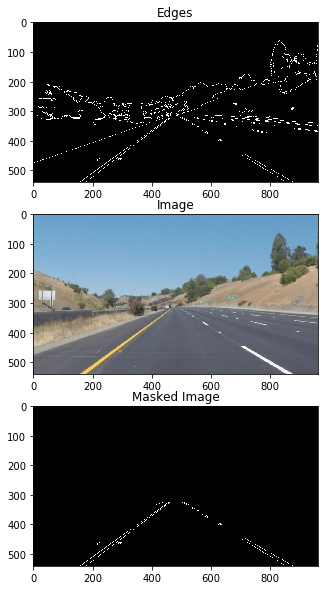

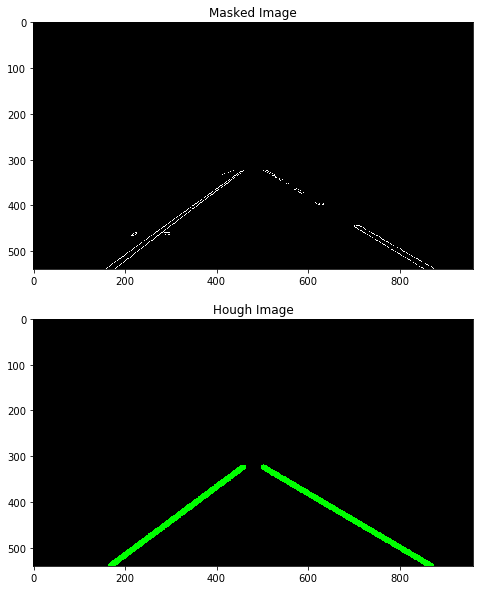

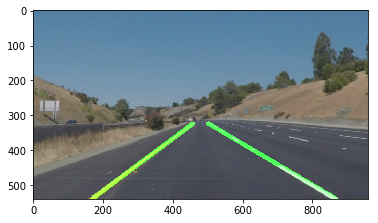

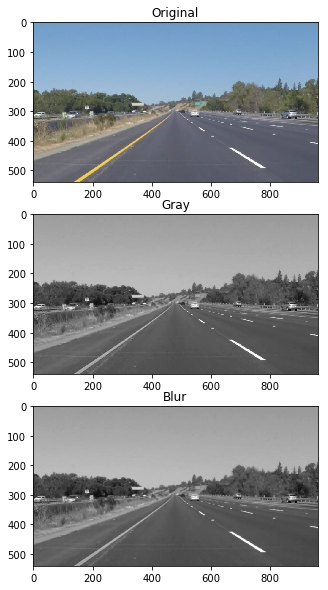

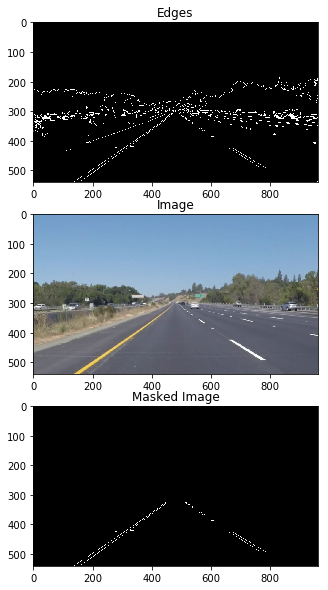

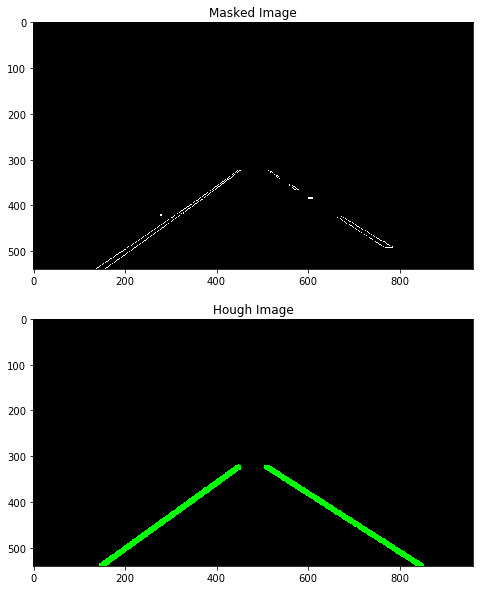

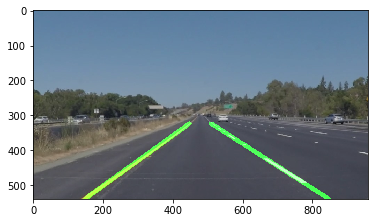

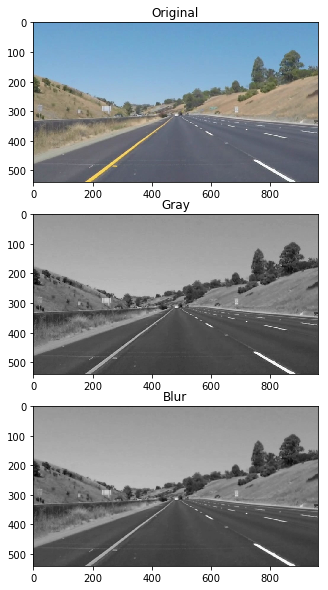

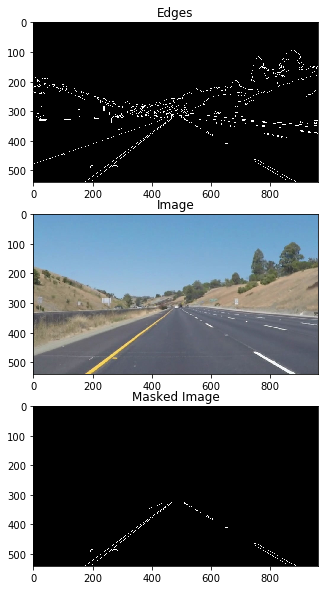

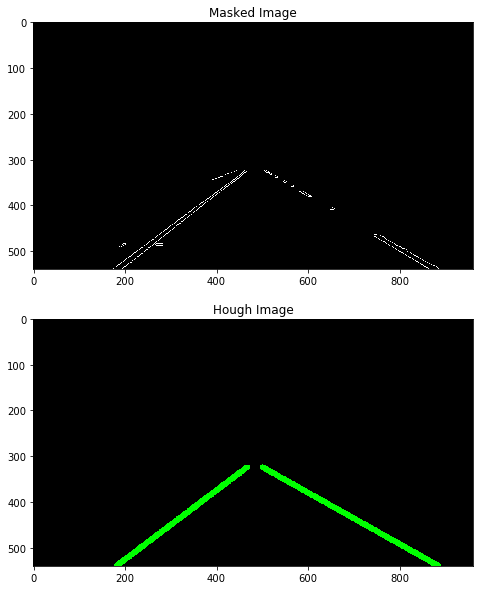

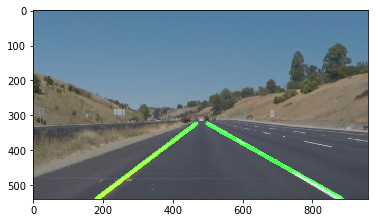

In [5]:
#Image Processing
import os
images = os.listdir("test_images/")
print('Images: {}'.format(images))

def readImage(image):
    image = mpimg.imread('test_images/' + image)
    gray = grayscale(image)
    blur = gaussian_blur(gray, 3)
    edges = canny(blur, 50, 150)
    masked_image = apply_mask(edges, image, gray)
    hough_image, lines = apply_hough(masked_image)
    hough_lines_weighted = apply_hough_lines_weighted(image, edges, hough_image)
    plot_original_gray_blur(image, gray, blur)
    plot_edges_mask(edges, image, masked_image)
    plot_hough(hough_image, masked_image)
    plot_hough_weighted(hough_lines_weighted)

readImage(images[0])

def readAllImages(images):
    for image in images:
        result = readImage(image)
    #    mpimg.imsave('result_images/' + '-ChangedParameters--'+image, result)

readAllImages(images)
    

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def readImageVideo(image):
    gray = grayscale(image)
    blur = gaussian_blur(gray, 3)
    edges = canny(blur, 50, 150)
    masked_image = apply_mask(edges, image, gray)
    hough_image, lines = apply_hough(masked_image)
    hough_lines_weighted = apply_hough_lines_weighted(image, edges, hough_image)
    return hough_lines_weighted

    

In [8]:
output_solidWhiteRight = 'whiteRight.mp4'
test1 = VideoFileClip('test_videos/solidWhiteRight.mp4')
solidWhiteRight_clip = test1.fl_image(readImageVideo)
%time solidWhiteRight_clip.write_videofile(output_solidWhiteRight, audio=False)

[MoviePy] >>>> Building video whiteRight.mp4
[MoviePy] Writing video whiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:07<00:00, 27.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: whiteRight.mp4 

Wall time: 9.15 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_solidWhiteRight))

In [10]:
output_solidYellowLeft = 'YellowLeft.mp4'
test2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
solidYellowLeft_clip = test2.fl_image(readImageVideo)
%time solidYellowLeft_clip.write_videofile(output_solidYellowLeft, audio=False)

[MoviePy] >>>> Building video YellowLeft.mp4
[MoviePy] Writing video YellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [00:26<00:00, 25.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: YellowLeft.mp4 

Wall time: 28 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_solidYellowLeft))

In [12]:
output_challenge = 'challengeOutput.mp4'
test3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = test3.fl_image(readImageVideo)
%time challenge_clip.write_videofile(output_challenge, audio=False)

[MoviePy] >>>> Building video challengeOutput.mp4
[MoviePy] Writing video challengeOutput.mp4


  6%|██▍                                      | 15/251 [00:00<00:09, 24.82it/s]

prev_right_x_max is not None


 11%|████▍                                    | 27/251 [00:01<00:09, 24.70it/s]

prev_right_x_max is not None


 16%|██████▎                                  | 39/251 [00:01<00:08, 25.28it/s]

prev_right_x_max is not None


 20%|████████▏                                | 50/251 [00:02<00:15, 12.99it/s]

prev_right_x_max is not None
prev_right_x_max is not None


 25%|██████████▏                              | 62/251 [00:03<00:14, 13.29it/s]

prev_right_x_max is not None


 38%|███████████████▋                         | 96/251 [00:06<00:11, 13.05it/s]

prev_right_x_max is not None


 39%|████████████████                         | 98/251 [00:06<00:12, 12.73it/s]

prev_right_x_max is not None


 42%|████████████████▉                       | 106/251 [00:06<00:11, 12.56it/s]

prev_left_x_max is not None
prev_left_x_max is not None


 43%|█████████████████▏                      | 108/251 [00:07<00:11, 12.76it/s]

prev_left_x_max is not None
prev_left_x_max is not None


 44%|█████████████████▌                      | 110/251 [00:07<00:13, 10.44it/s]

prev_left_x_max is not None
prev_left_x_max is not None


 45%|█████████████████▊                      | 112/251 [00:07<00:13, 10.68it/s]

prev_left_x_max is not None
prev_right_x_max is not None


 45%|██████████████████▏                     | 114/251 [00:07<00:12, 11.11it/s]

prev_left_x_max is not None
prev_left_x_max is not None


 46%|██████████████████▍                     | 116/251 [00:07<00:11, 11.46it/s]

prev_left_x_max is not None


 47%|██████████████████▊                     | 118/251 [00:08<00:12, 10.64it/s]

prev_left_x_max is not None
prev_left_x_max is not None


 48%|███████████████████                     | 120/251 [00:08<00:11, 11.35it/s]

prev_left_x_max is not None
prev_left_x_max is not None


 49%|███████████████████▍                    | 122/251 [00:08<00:13,  9.56it/s]

prev_left_x_max is not None
prev_left_x_max is not None


 49%|███████████████████▊                    | 124/251 [00:08<00:13,  9.76it/s]

prev_left_x_max is not None
prev_right_x_max is not None
prev_left_x_max is not None
prev_right_x_max is not None


 50%|████████████████████                    | 126/251 [00:09<00:13,  8.97it/s]

prev_left_x_max is not None
prev_left_x_max is not None


 51%|████████████████████▍                   | 128/251 [00:09<00:12,  9.98it/s]

prev_left_x_max is not None


 53%|█████████████████████                   | 132/251 [00:09<00:11, 10.26it/s]

prev_left_x_max is not None


 53%|█████████████████████▎                  | 134/251 [00:09<00:14,  8.30it/s]

prev_left_x_max is not None


 54%|█████████████████████▌                  | 135/251 [00:10<00:13,  8.48it/s]

prev_left_x_max is not None


 55%|█████████████████████▉                  | 138/251 [00:10<00:11,  9.87it/s]

prev_left_x_max is not None


 57%|██████████████████████▋                 | 142/251 [00:10<00:10, 10.14it/s]

prev_left_x_max is not None


 57%|██████████████████████▉                 | 144/251 [00:10<00:10, 10.30it/s]

prev_left_x_max is not None


 62%|████████████████████████▊               | 156/251 [00:11<00:08, 11.48it/s]

prev_right_x_max is not None


 63%|█████████████████████████▏              | 158/251 [00:12<00:08, 10.57it/s]

prev_right_x_max is not None
prev_right_x_max is not None


 68%|███████████████████████████             | 170/251 [00:13<00:08,  9.46it/s]

prev_right_x_max is not None


 72%|████████████████████████████▋           | 180/251 [00:14<00:06, 11.26it/s]

prev_right_x_max is not None


 85%|██████████████████████████████████      | 214/251 [00:17<00:03, 10.28it/s]

prev_right_x_max is not None


 99%|███████████████████████████████████████▌| 248/251 [00:20<00:00, 12.44it/s]

prev_right_x_max is not None


100%|███████████████████████████████████████▊| 250/251 [00:20<00:00, 12.92it/s]

prev_right_x_max is not None


100%|████████████████████████████████████████| 251/251 [00:20<00:00, 12.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challengeOutput.mp4 

Wall time: 23.2 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_challenge))